# Treebank NER with Bi-LSTM-CRF 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [6]:
from conlleval import evaluate

In [7]:
from ner_utils import *

Using TensorFlow backend.
/home/nlp/danb/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nlp/danb/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nlp/danb/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nlp/danb/anaconda3/e

## Get token data

In [8]:
import sys
sys.path.append('/home/nlp/danb')
import bclm

In [9]:
dropped = [5438, 5444, 5445, 5446, 5448, 5449, 5450, 5451, 5453, 5459]
spdf = bclm.read_dataframe('spmrl')
spdf = spdf[(~spdf.sent_id.isin(dropped))]
tokens_ner_with_upos = bclm.get_token_df(spdf, fields = ['biose_layer0', 'upostag'])
tokens_ner_with_upos.head()

,sent_id,token_id,token_str,biose_layer0,upostag,set
0,1,1,עשרות,O,CDT,dev
1,1,2,אנשים,O,NN,dev
2,1,3,מגיעים,O,BN,dev
3,1,4,מתאילנד,O^S-GPE,PREPOSITION^NNP,dev
4,1,5,לישראל,O^S-GPE,PREPOSITION^NNP,dev


In [10]:
yap_dev_tok = bclm.get_token_df(bclm.read_yap_output(treebank_set='dev'), fields=['upostag'])
yap_test_tok = bclm.get_token_df(bclm.read_yap_output(treebank_set='test'), fields=['upostag'])

In [11]:
yap_test_tok.head()

,sent_id,token_id,token_str,upostag
0,1,1,הכל,DEF^DTT
1,1,2,נושאים,NN
2,1,3,עמם,VB
3,1,4,את,AT
4,1,5,כישלונות,NNT


In [12]:
yap_dev_tok.head()

,sent_id,token_id,token_str,upostag
0,1,1,עשרות,CDT
1,1,2,אנשים,NN
2,1,3,מגיעים,BN
3,1,4,מתאילנד,PREPOSITION^NNP
4,1,5,לישראל,NNP


In [13]:
yap_dev_tok_sents =  yap_dev_tok.groupby('sent_id')[['token_str', 'upostag']].apply(lambda x: x.values.tolist())
yap_dev_tok_sents.head()

sent_id
1    [[עשרות, CDT], [אנשים, NN], [מגיעים, BN], [מתא...
2    [[תופעה, NN], [זו, PRP], [התבררה, VB], [אתמול,...
3    [[יו"ר, NNT], [הוועדה, DEF^NN], [,, yyCM], [ח"...
4    [[מצד, PREPOSITION^NN], [אחד, CD], [רוצה, BN],...
5    [[נמיר, NNP], [הודיעה, VB], [כי, CC], [תפנה, V...
dtype: object

In [14]:
yap_test_tok_sents =  yap_test_tok.groupby('sent_id')[['token_str', 'upostag']].apply(lambda x: x.values.tolist())
yap_test_tok_sents.head()

sent_id
1    [[הכל, DEF^DTT], [נושאים, NN], [עמם, VB], [את,...
2    [[אומר, NNT], [מזכיר, NNT], [התק"ם, DEF^NNP], ...
3    [[לא, RB], [ייתכן, MD], [שעולה, REL^NN], [יבוא...
4    [[לא, RB], [ייתכן, MD], [שהוא, REL^PRP], [יירד...
5    [[לכן, CC], [קבענו, VB], [עיקרון, NN], [שצריכה...
dtype: object

In [15]:
gold_dev   = tokens_ner_with_upos[tokens_ner_with_upos.set=='dev']
gold_train = tokens_ner_with_upos[tokens_ner_with_upos.set=='train']
gold_test  = tokens_ner_with_upos[tokens_ner_with_upos.set=='test']
gold_test.head()

,sent_id,token_id,token_str,biose_layer0,upostag,set
102035,5439,1,הכל,O,NN,test
102036,5439,2,נושאים,O,BN,test
102037,5439,3,עמם,O^O,IN^S_PRN,test
102038,5439,4,את,O,AT,test
102039,5439,5,כישלונות,O,NNT,test


In [16]:
gold_dev_sents = gold_dev.groupby('sent_id')    [['token_str', 'upostag', 'biose_layer0']].apply(lambda x: x.values.tolist())
gold_train_sents = gold_train.groupby('sent_id')[['token_str', 'upostag', 'biose_layer0']].apply(lambda x: x.values.tolist())
gold_test_sents = gold_test.groupby('sent_id')  [['token_str', 'upostag', 'biose_layer0']].apply(lambda x: x.values.tolist())
gold_test_sents.head()

sent_id
5439    [[הכל, NN, O], [נושאים, BN, O], [עמם, IN^S_PRN...
5440    [[אומר, BN, O], [מזכיר, NNT, O], [התק"ם, NNP, ...
5441    [[לא, RB, O], [ייתכן, MD, O], [שעולה, REL^NN, ...
5442    [[לא, RB, O], [ייתכן, MD, O], [שהוא, REL^PRP, ...
5443    [[לכן, CC, O], [קבענו, VB, O], [עיקרון, NN, O]...
dtype: object

In [17]:
gold_dev_sents.head()

sent_id
1    [[עשרות, CDT, O], [אנשים, NN, O], [מגיעים, BN,...
2    [[תופעה, NN, O], [זו, PRP, O], [התבררה, VB, O]...
3    [[יו"ר, NNT, O], [הוועדה, DEF^NN, O^O], [,, yy...
4    [[מצד, PREPOSITION^NN, O^O], [אחד, CD, O], [רו...
5    [[נמיר, NNP, S-PER], [הודיעה, VB, O], [כי, CC,...
dtype: object

In [18]:
words = list(set(tokens_ner_with_upos.token_str.values)
             | set(yap_dev_tok.token_str.values)
             | set(yap_test_tok.token_str.values))
n_words = len(words); n_words

28714

In [19]:
tags = list(set(tokens_ner_with_upos.biose_layer0.values))
n_tags = len(tags); n_tags

130

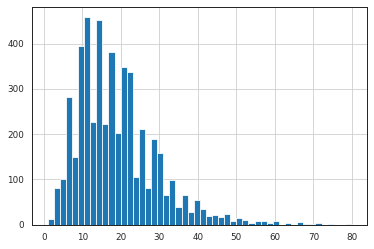

In [20]:
gold_train.groupby('sent_id').size().hist(bins=50)

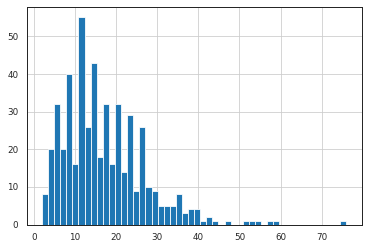

In [21]:
yap_dev_tok.groupby('sent_id').size().hist(bins=50)

In [22]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [23]:
from keras.preprocessing.sequence import pad_sequences
X_gold_train = [[word2idx[w[0]] for w in s] for s in gold_train_sents]
X_gold_dev   = [[word2idx[w[0]] for w in s] for s in gold_dev_sents]
X_gold_test  = [[word2idx[w[0]] for w in s] for s in gold_test_sents]
X_yap_dev    = [[word2idx[w[0]] for w in s] for s in yap_dev_tok_sents]
X_yap_test   = [[word2idx[w[0]] for w in s] for s in yap_test_tok_sents]

In [24]:
X_gold_train = pad_sequences(maxlen=max_len, sequences=X_gold_train, value=word2idx["PAD"], padding='post', truncating='post')
X_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_gold_dev  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_test  = pad_sequences(maxlen=max_len, sequences=X_gold_test , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_yap_dev   , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_test   = pad_sequences(maxlen=max_len, sequences=X_yap_test  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_train[0]

array([ 2295,   148,  7592, 22887,  1848,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [25]:
pos = list(set(tokens_ner_with_upos.upostag.values)|set(yap_dev_tok.upostag.values)|set(yap_test_tok.upostag.values))
n_pos = len(pos); n_pos

352

In [26]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0

In [27]:
from keras.preprocessing.sequence import pad_sequences
X_pos_gold_train = [[pos2idx[w[1]] for w in s] for s in gold_train_sents]
X_pos_gold_dev   = [[pos2idx[w[1]] for w in s] for s in gold_dev_sents]
X_pos_gold_test  = [[pos2idx[w[1]] for w in s] for s in gold_test_sents]
X_pos_yap_dev    = [[pos2idx[w[1]] for w in s] for s in yap_dev_tok_sents]
X_pos_yap_test   = [[pos2idx[w[1]] for w in s] for s in yap_test_tok_sents]

In [28]:
X_pos_gold_train = pad_sequences(maxlen=max_len, sequences=X_pos_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_pos_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_test  = pad_sequences(maxlen=max_len, sequences=X_pos_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_pos_yap_dev   , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_test   = pad_sequences(maxlen=max_len, sequences=X_pos_yap_test  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_train[0]

array([ 82,   9, 313, 295, 153,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [29]:
from keras.preprocessing.sequence import pad_sequences
y_gold_train = [[tag2idx[w[2]] for w in s] for s in gold_train_sents]
y_gold_dev   = [[tag2idx[w[2]] for w in s] for s in gold_dev_sents]
y_gold_test  = [[tag2idx[w[2]] for w in s] for s in gold_test_sents]

In [30]:
y_numer_gold_train = pad_sequences(maxlen=max_len, sequences=y_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_dev   = pad_sequences(maxlen=max_len, sequences=y_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_test  = pad_sequences(maxlen=max_len, sequences=y_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_train[0]

array([121, 121, 121,  54, 121,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [31]:
from keras.utils import to_categorical
y_gold_train = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_train]
y_gold_dev   = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_dev  ]
y_gold_test  = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_test ]

y_gold_train[0].shape

(80, 131)

In [32]:
validation_split = len(X_gold_dev) / (len(X_gold_train)+len(X_gold_dev))
validation_split

0.09196247930844216

In [33]:
splits = [[X_gold_train, X_gold_dev,
           y_gold_train, y_gold_dev,
           X_pos_gold_train, X_pos_gold_dev ]]

### Prep char input

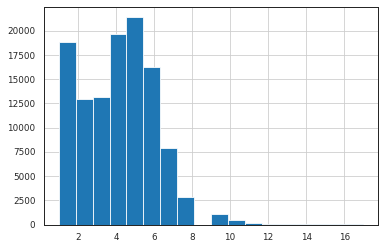

In [34]:
tokens_ner_with_upos.token_str.apply(len).hist(bins=18)

In [35]:
max_len_char = 12

In [36]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

50


In [37]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [38]:

def get_X_char(sents):
    X_char = []
    for sentence in sents:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return X_char

In [39]:
X_char_gold_dev   = get_X_char(gold_dev_sents  )
X_char_gold_train = get_X_char(gold_train_sents)
X_char_gold_test  = get_X_char(gold_test_sents )
X_char_yap_dev    = get_X_char(yap_dev_tok_sents   )
X_char_yap_test   = get_X_char(yap_test_tok_sents  )



splits_char = [[X_char_gold_train, X_char_gold_dev,
                y_gold_train, y_gold_dev]]

## Embeddings

In [40]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.glove.txt',
 'yap_ft_sg': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.fasttext_cbow.model.vec',

In [41]:
exclude = ['tuned', 'cbow', 'yap', 'orig', '/fasttext/']
include = 'ft'

In [42]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    if include not in emb_name:
        continue
        
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

loading word embeddings: ../wordembedding-hebrew/vectors_alt_tok/wikipedia.alt_tok.tokenized.fasttext_skipgram.model.vec
found 359321 word vectors
preparing embedding matrix...
number of null word embeddings: 3028
sample words not found:  ['שנפיק' 'למופקדים' 'מאלמוניות' 'ומתסכלת' 'מגוייס' 'כ057' 'שיתכנס'
 'לפראנצסקה' 'במוסקווה' 'ל3.1']


## Model building

In [43]:
from ner_utils import *

In [44]:
configs = build_configs(base_configs_stack_freeze, embedding_mats)
configs     

[{'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'alt_tok_token_ft_sg',
  'trainable': False,
  'stack_lstm': 2},
 {'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': True,
  'embedding_matrix': 'alt_tok_token_ft_sg',
  'trainable': False,
  'stack_lstm': 2}]

In [45]:
for conf in configs:
    conf['patience'] = 10

In [46]:
out_folder = 'results/new_outputs_no_biose_fix'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [47]:
extra_preds = [(X_gold_test, X_pos_gold_test, X_char_gold_test), 
               (X_yap_dev, X_pos_yap_dev, X_char_yap_dev),
               (X_yap_test, X_pos_yap_test, X_char_yap_test)]

In [48]:
from ner_utils import *

In [ ]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='treebank_tokens_no_biose_fix', out_folder=out_folder,
                                                skip_if_model_exists=True,
                                                validation_split=validation_split,
                                                extra_predictions=extra_preds,
                                                evaluate_preds=False,
                                                )






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 12)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 80, 12, 20)   1040        input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
from keras import backend as K
K.clear_session()